In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [98]:
from pathlib import Path

base_dir = Path().resolve()
file_path = base_dir.parent / 'data' / 'medicare_data_cleaned.parquet'

if not file_path.exists():
    print(f"File not found: {file_path}")
    print("Files in directory:", list(file_path.parent.glob("*")))
else:
    df = pd.read_parquet(file_path)

In [99]:
common_drgs = df['DRG_Cd'].value_counts(
)[df['DRG_Cd'].value_counts() > 20].index

df['drg_grouped'] = df['DRG_Cd'].apply(
    lambda x: x if x in common_drgs else 'Other')

In [ ]:
X = df.drop(columns = ['Tot_Dschrgs', 'Avg_Submtd_Cvrd_Chrg',
            'Avg_Tot_Pymt_Amt', 'Avg_Mdcr_Pymt_Amt','Rndrng_Prvdr_Org_Name',  'Rndrng_Prvdr_City',    
        'Rndrng_Prvdr_St',  'Rndrng_Prvdr_State_Abrvtn'])

y = df['Avg_Mdcr_Pymt_Amt']

In [101]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ['Rndrng_Prvdr_CCN', 'DRG_Cd',
                    'RUCA_category', 'Rndrng_Prvdr_State_FIPS',
                    'Rndrng_Prvdr_Zip5', 'drg_grouped','year']


preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# ColumnTransformer([
#     (name, transformer, columns)
# ])

# name: a string label (e.g., 'cat', 'num', 'text')
# transformer: the object doing the transformation (e.g., OneHotEncoder)
# columns: list of columns to apply it to

In [102]:
from sklearn.model_selection import train_test_split

y_binned = pd.qcut(y, q=5, labels=False)

# Stratified split on the binned target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_binned)

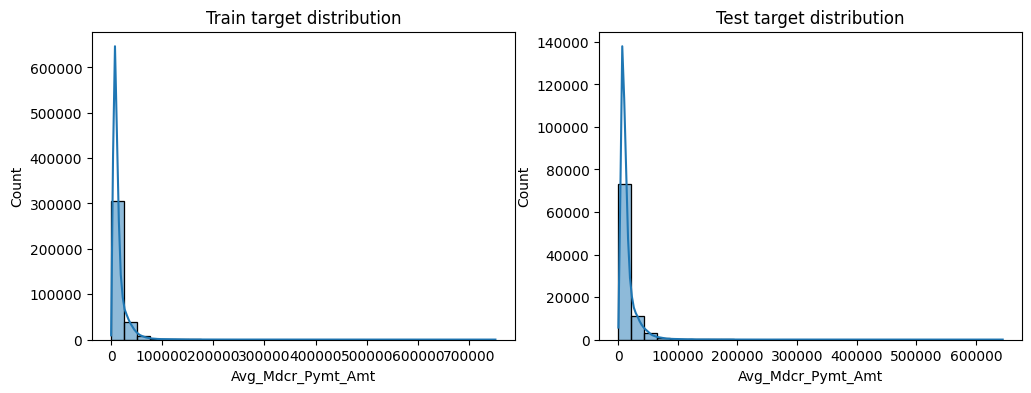

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(y_train, bins=30, ax=axes[0], kde=True)
axes[0].set_title("Train target distribution")
sns.histplot(y_test, bins=30, ax=axes[1], kde=True)
axes[1].set_title("Test target distribution")
plt.show()

In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor


model = Pipeline([
    ("preprocess", preprocessor),
    ("xgb", XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    ))
])

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


# before stratified
# MAE: 6778.400358337291
# MSE: 111797814.11404487
# RMSE: 10573.448544067582
# R²: 0.6766423622930794

MAE: 6770.025367520147
MSE: 106608351.5633039
RMSE: 10325.13203611963
R²: 0.6846058718249348


In [104]:
import optuna

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0)
    }

    preprocessor.fit(X_train)
    
    X_train_enc = preprocessor.transform(X_train)
    X_test_enc = preprocessor.transform(X_test)

    xgb = XGBRegressor(**param)
    xgb.fit(X_train_enc, y_train)
    
    y_pred = xgb.predict(X_test_enc)
    r2 = r2_score(y_test, y_pred)

    return r2


optuna_study = optuna.create_study(direction='maximize')
optuna_study.optimize(objective, n_trials=100)

print("Best parameters:", optuna_study.best_params)
print("Best mae score:", optuna_study.best_value)

[I 2025-06-28 20:25:07,162] A new study created in memory with name: no-name-4fc147ae-ecab-41e1-a682-a653d160d9be
[I 2025-06-28 20:25:09,888] Trial 0 finished with value: 0.9323891865415009 and parameters: {'n_estimators': 272, 'max_depth': 7, 'learning_rate': 0.25968841870514875, 'gamma': 0.3726908537790319}. Best is trial 0 with value: 0.9323891865415009.
[I 2025-06-28 20:25:12,782] Trial 1 finished with value: 0.8908669018623068 and parameters: {'n_estimators': 281, 'max_depth': 8, 'learning_rate': 0.07928636589513946, 'gamma': 4.859834987832049}. Best is trial 0 with value: 0.9323891865415009.
[I 2025-06-28 20:25:15,694] Trial 2 finished with value: 0.8374409513882162 and parameters: {'n_estimators': 230, 'max_depth': 9, 'learning_rate': 0.04438777974411927, 'gamma': 0.038545641460939195}. Best is trial 0 with value: 0.9323891865415009.
[I 2025-06-28 20:25:18,082] Trial 3 finished with value: 0.9195922296152546 and parameters: {'n_estimators': 229, 'max_depth': 8, 'learning_rate': 

Best parameters: {'n_estimators': 296, 'max_depth': 10, 'learning_rate': 0.28066040190936903, 'gamma': 1.795335805844837}
Best mae score: 0.9457752330602927


In [105]:
import optuna.visualization as vis

vis.plot_optimization_history(optuna_study).show()
vis.plot_param_importances(optuna_study).show()

In [106]:
# Re-create and train model using best parameters from Optuna
xgb_optuna = XGBRegressor(**optuna_study.best_params)
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

xgb_optuna.fit(X_train_enc, y_train)
y_pred_optuna = xgb_optuna.predict(X_test_enc)

# Evaluate
print("MAE:", mean_absolute_error(y_test, y_pred_optuna))
print("MSE:", mean_squared_error(y_test, y_pred_optuna))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_optuna)))
print("R²:", r2_score(y_test, y_pred_optuna))

MAE: 1891.1119460004645
MSE: 18328854.283989076
RMSE: 4281.221120660445
R²: 0.9457752330602927


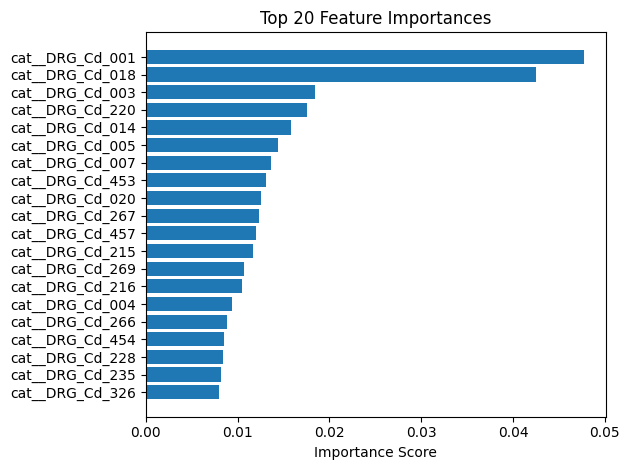

In [115]:
# Get feature names AFTER fitting the preprocessor

xgb_optuna = XGBRegressor(**optuna_study.best_params)
xgb_optuna.fit(X_train_enc, y_train)

feature_names = preprocessor.get_feature_names_out(X_train.columns)
importances = xgb_optuna.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)


plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()  # flip y-axis so largest is at bottom
plt.xlabel("Importance Score")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [108]:
import joblib

joblib.dump(model, "xgb_pipeline.joblib")

# use later like this 

# model_loaded = joblib.load("xgb_pipeline.joblib")
# y_pred = model_loaded.predict(X_new)

['xgb_pipeline.joblib']

Text(0.5, 1.0, 'Predicted vs. Actual')

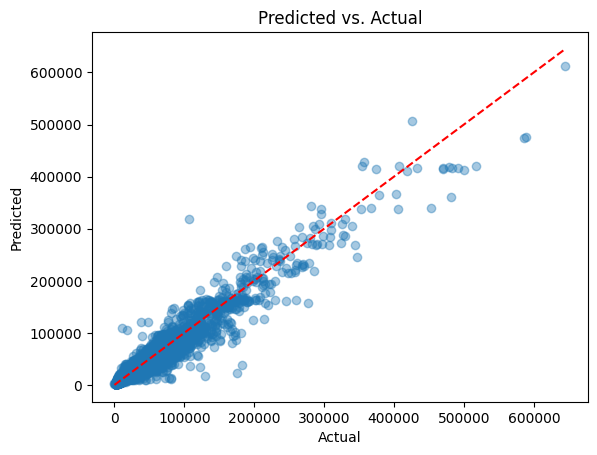

In [109]:
plt.scatter(y_test, y_pred_optuna, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual")

In [110]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(
    model, X, y, scoring='neg_mean_absolute_error', cv=5)
print(f"CV MAE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

CV MAE: 6911.24 ± 594.03


In [111]:
print("Fold MAEs:", -cv_scores)

Fold MAEs: [7800.03419627 6233.2255431  7204.15479678 7048.01848862 6270.77639539]
